In [1]:
import pandas as pd
from os import walk

In [1]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

stop_words = stopwords.words('english')
porter = PorterStemmer()

# Data Pre-Processing

In [3]:
"""
Clean all text data
- file_path where files are located in directory
"""
def clean_text_for_files(file_path):
    all_texts = []
    for filename in os.listdir(file_path):
        if filename.endswith(".txt"):
            with open(os.path.join(file_path, filename), 'r', encoding='utf-8') as file:
                # reads in file 
                text = file.read()
                # splits into words
                words = re.split(r'\W+',text)
                # makes all lowercase
                lower_words = [word.lower() for word in words ]
                # removes stop words
                re_stop_words = [word for word in lower_words if not word in stop_words]
                # gets the stems of words
                stem_words = [porter.stem(word) for word in re_stop_words]
                # reappends together with spaces
                all_texts.append(" ".join(stem_words))
    return all_texts
    

In [4]:
# clean train data
pos_train = clean_text_for_files('data/train/pos')
neg_train = clean_text_for_files('data/train/neg')

In [5]:
# create labels for positive and negative train, and append data to make whole train file
pos_labels_train = [1] * len(pos_train)
neg_labels_train = [0] * len(neg_train)

all_text_train = pos_train + neg_train 
all_text_labels_train = np.array(pos_labels_train +neg_labels_train)

In [6]:
# clean test data
pos_test = clean_text_for_files('data/test/pos')
neg_test = clean_text_for_files('data/test/neg')

In [7]:
# create labels for positive and negative test, and append data to make whole test file
pos_labels_test = [1] * len(pos_test)
neg_labels_test = [0] * len(neg_test)

all_text_test = pos_test + neg_test
all_labels_test = np.array(pos_labels_test + neg_labels_test)

In [8]:
# set max words and the max length
max_words = 100_000
max_len = 100

# tokenizes the sentences into the max words
tokenizer = Tokenizer(num_words = max_words)

# fits on text and sequences the data
tokenizer.fit_on_texts(all_text_train)
sequences = tokenizer.texts_to_sequences(all_text_train)

# pads and truncates text b/c different sizes 
padd_sequences = pad_sequences(sequences, maxlen = max_len)

word_index = tokenizer.word_index
vocabulary = set(word_index.keys())

# creates train and validation sets
X_train, X_val, y_train, y_val = train_test_split(padd_sequences, all_text_labels_train, test_size = 0.2, random_state=42)

# gets sequences on text data and pads data
sequences_test = tokenizer.texts_to_sequences(all_text_test)

padd_sequences_test = pad_sequences(sequences_test, maxlen = max_len)

# Create Metrics

In [11]:
def f1_score(y_true, y_pred):
    # Ensure that both y_true and y_pred are cast to float32
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.round(y_pred)  # Round predicted probabilities to 0 or 1
    
    # True positives, false positives, false negatives
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, 'float32'), axis=0)
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, 'float32'), axis=0)
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), 'float32'), axis=0)

    # Precision and recall
    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())

    # F1 score
    f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
    return tf.reduce_mean(f1)

def recall_score(y_true, y_pred):
    # Ensure that both y_true and y_pred are cast to float32
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.round(y_pred)  # Round predicted probabilities to 0 or 1
    
    # True positives, false positives, false negatives
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, 'float32'), axis=0)
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, 'float32'), axis=0)
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), 'float32'), axis=0)

    recall = tp / (tp + fn + tf.keras.backend.epsilon())

    return tf.reduce_mean(recall)

def precision_score(y_true, y_pred):
    # Ensure that both y_true and y_pred are cast to float32
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.round(y_pred)  # Round predicted probabilities to 0 or 1
    
    # True positives, false positives, false negatives
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, 'float32'), axis=0)
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, 'float32'), axis=0)
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), 'float32'), axis=0)

    # Precision and recall
    precision = tp / (tp + fp + tf.keras.backend.epsilon())

    return tf.reduce_mean(precision)


# Training Convergence Plot

In [17]:
def plot_convergence(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1,len(train_loss) + 1)

    # Plotting loss over epochs
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss,label='Validation Loss')
    plt.title('Loss Convergence Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Base Model

In [26]:
vocab_size = min(max_words, len(tokenizer.word_index) + 1)
embedding_dim = 100

model = Sequential()

model.add(Embedding(input_dim = vocab_size, output_dim = embedding_dim, input_length = max_len))
model.add(SimpleRNN(units=100, return_sequences=False))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy',f1_score, recall_score, precision_score])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=50, batch_size=100, 
                    validation_data=(X_val, y_val), 
                    callbacks=[early_stopping])

Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.5237 - f1_score: 0.3029 - loss: 0.6891 - precision_score: 0.4782 - recall_score: 0.2481 - val_accuracy: 0.7032 - val_f1_score: 0.2547 - val_loss: 0.5459 - val_precision_score: 0.5030 - val_recall_score: 0.1713
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.8343 - f1_score: 0.3360 - loss: 0.3805 - precision_score: 0.5039 - recall_score: 0.2542 - val_accuracy: 0.8434 - val_f1_score: 0.3607 - val_loss: 0.3726 - val_precision_score: 0.5030 - val_recall_score: 0.2820
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.9211 - f1_score: 0.3363 - loss: 0.2102 - precision_score: 0.5033 - recall_score: 0.2535 - val_accuracy: 0.8064 - val_f1_score: 0.3557 - val_loss: 0.4459 - val_precision_score: 0.5030 - val_recall_score: 0.2760
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.9309 - f1_score: 0.3349 - loss: 0.1891 - precision_score: 0.5040 - recall_score: 0.2517 - val_accuracy

In [27]:
loss, accuracy, f1, precision, recall = model.evaluate(padd_sequences_test, all_labels_test)

782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8620 - f1_score: 0.7891 - loss: 0.3268 - precision_score: 0.8455 - recall_score: 0.7412


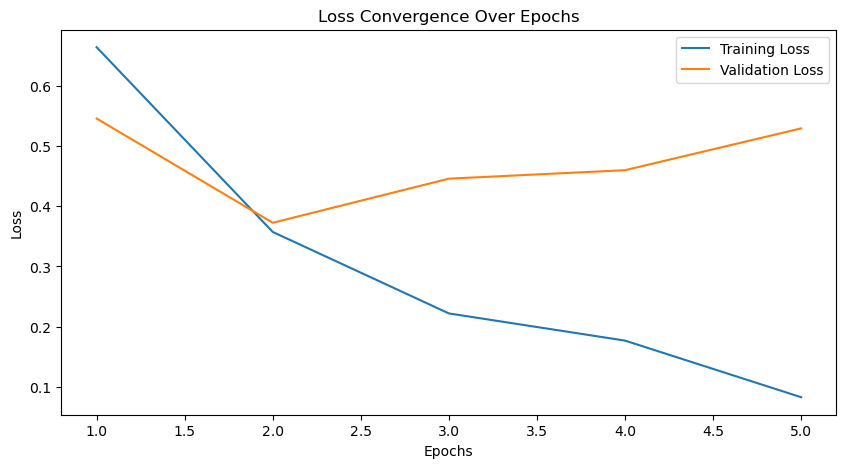

In [33]:
plot_convergence(history)

# Ablation Studies

In [42]:
max_words_1 = 1_000 # change from 100_000
max_len_1 = 100

tokenizer_1 = Tokenizer(num_words = max_words_1)
tokenizer_1.fit_on_texts(all_text_train)
sequences_1 = tokenizer_1.texts_to_sequences(all_text_train)

padd_sequences_1 = pad_sequences(sequences_1, maxlen = max_len_1)

word_index_1 = tokenizer_1.word_index

vocabulary_1 = set(word_index_1.keys())

X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(padd_sequences_1, all_text_labels_train, test_size = 0.2, random_state=42)

sequences_test_1 = tokenizer_1.texts_to_sequences(all_text_test)

padd_sequences_test_1 = pad_sequences(sequences_test_1, maxlen = max_len_1)


# Vocabulary size (based on tokenizer) and embedding dimension
vocab_size_1 = min(max_words_1, len(tokenizer_1.word_index) + 1)  # Cap the vocabulary size
embedding_dim_1 = 100  # Dimension of embedding vector

# Build the RNN model
model_1 = Sequential()

# Embedding layer
model_1.add(Embedding(input_dim=vocab_size_1, output_dim=embedding_dim_1, input_length=max_len_1))

# Simple RNN layer
model_1.add(SimpleRNN(units=100, return_sequences=False))

# Fully connected layer
model_1.add(Dense(64, activation='relu'))

# Output layer for binary classification
model_1.add(Dense(1, activation='sigmoid'))

model_1.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy',f1_score, recall_score, precision_score])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_1 = model_1.fit(X_train_1, y_train_1, epochs=50, batch_size=100, 
                    validation_data=(X_val_1, y_val_1), 
                    callbacks=[early_stopping])

Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.5723 - f1_score: 0.2908 - loss: 0.6509 - precision_score: 0.5020 - recall_score: 0.2213 - val_accuracy: 0.8210 - val_f1_score: 0.3602 - val_loss: 0.4067 - val_precision_score: 0.5030 - val_recall_score: 0.2814
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.8349 - f1_score: 0.3418 - loss: 0.3799 - precision_score: 0.5010 - recall_score: 0.2609 - val_accuracy: 0.8452 - val_f1_score: 0.3548 - val_loss: 0.3612 - val_precision_score: 0.5030 - val_recall_score: 0.2748
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.8718 - f1_score: 0.3351 - loss: 0.3095 - precision_score: 0.4967 - recall_score: 0.2540 - val_accuracy: 0.8292 - val_f1_score: 0.3229 - val_loss: 0.3979 - val_precision_score: 0.5030 - val_recall_score: 0.2386
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.9044 - f1_score: 0.3342 - loss: 0.2404 - precision_score: 0.5011 - recall_score: 0.2519 - val_accuracy

In [45]:
loss, accuracy, f1, precision, recall = model_1.evaluate(padd_sequences_test_1, all_labels_test)

782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8671 - f1_score: 0.7894 - loss: 0.3446 - precision_score: 0.8455 - recall_score: 0.7420


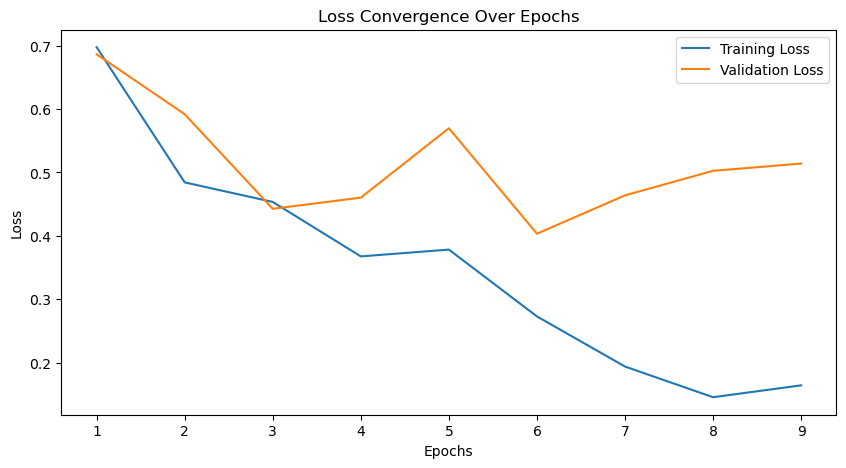

In [34]:
plot_convergence(history_1)

In [87]:
vocab_size = min(max_words, len(tokenizer.word_index) + 1)
embedding_dim = 100

model_2 = Sequential()

model_2.add(Embedding(input_dim = vocab_size, output_dim = embedding_dim, input_length = max_len))
model_2.add(SimpleRNN(units=1_000, return_sequences=False))
model_2.add(Dense(64, activation='relu'))
model_2.add(Dense(1, activation='sigmoid'))

model_2.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy',f1_score, recall_score, precision_score])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_2 = model_2.fit(X_train, y_train, epochs=50, batch_size=32, 
                    validation_data=(X_val, y_val), 
                    callbacks=[early_stopping])

Epoch 1/50


/opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


625/625 ━━━━━━━━━━━━━━━━━━━━ 150s 239ms/step - accuracy: 0.5068 - f1_score: 0.2942 - loss: 0.9073 - precision_score: 0.4517 - recall_score: 0.2490 - val_accuracy: 0.4956 - val_f1_score: 0.1012 - val_loss: 0.7332 - val_precision_score: 0.4942 - val_recall_score: 0.0575
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 145s 232ms/step - accuracy: 0.5039 - f1_score: 0.2770 - loss: 0.7340 - precision_score: 0.4576 - recall_score: 0.2409 - val_accuracy: 0.5030 - val_f1_score: 0.5042 - val_loss: 0.7160 - val_precision_score: 0.5042 - val_recall_score: 0.5042
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 141s 225ms/step - accuracy: 0.5040 - f1_score: 0.2911 - loss: 0.7135 - precision_score: 0.4349 - recall_score: 0.2607 - val_accuracy: 0.5022 - val_f1_score: 0.2209 - val_loss: 0.7016 - val_precision_score: 0.5042 - val_recall_score: 0.1434
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 138s 221ms/step - accuracy: 0.5083 - f1_score: 0.2433 - loss: 0.7035 - precision_score: 0.4519 - recall_score: 0.2039 - val_accurac

In [89]:
loss, accuracy, f1, precision, recall = model_2.evaluate(padd_sequences_test, all_labels_test)

782/782 ━━━━━━━━━━━━━━━━━━━━ 59s 75ms/step - accuracy: 0.6394 - f1_score: 0.6382 - loss: 0.7280 - precision_score: 0.8455 - recall_score: 0.5169


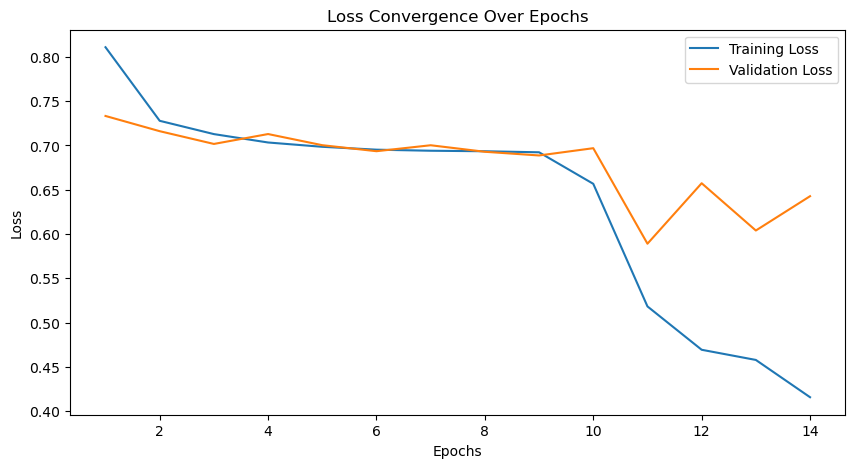

In [90]:
plot_convergence(history_2)

# Other Studies

In [91]:
vocab_size = min(max_words, len(tokenizer.word_index) + 1)
embedding_dim = 100

model_4 = Sequential()

model_4.add(Embedding(input_dim = vocab_size, output_dim = embedding_dim, input_length = max_len))
model_4.add(SimpleRNN(units=500, return_sequences=False)) # changed from 100 to 500
model_4.add(Dense(64, activation='relu'))
model_4.add(Dense(1, activation='sigmoid'))

model_4.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy',f1_score, recall_score, precision_score])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_4 = model_2.fit(X_train, y_train, epochs=50, batch_size=32, 
                    validation_data=(X_val, y_val), 
                    callbacks=[early_stopping])

Epoch 1/50


/opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


625/625 ━━━━━━━━━━━━━━━━━━━━ 152s 243ms/step - accuracy: 0.8156 - f1_score: 0.3378 - loss: 0.4386 - precision_score: 0.5029 - recall_score: 0.2581 - val_accuracy: 0.7352 - val_f1_score: 0.3448 - val_loss: 0.5926 - val_precision_score: 0.5042 - val_recall_score: 0.2646
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 151s 241ms/step - accuracy: 0.8460 - f1_score: 0.3338 - loss: 0.3939 - precision_score: 0.5000 - recall_score: 0.2534 - val_accuracy: 0.7226 - val_f1_score: 0.3569 - val_loss: 0.5878 - val_precision_score: 0.5042 - val_recall_score: 0.2786
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 158s 253ms/step - accuracy: 0.8493 - f1_score: 0.3409 - loss: 0.3864 - precision_score: 0.5041 - recall_score: 0.2609 - val_accuracy: 0.7112 - val_f1_score: 0.3140 - val_loss: 0.5852 - val_precision_score: 0.5042 - val_recall_score: 0.2307
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 150s 240ms/step - accuracy: 0.8614 - f1_score: 0.3348 - loss: 0.3666 - precision_score: 0.5007 - recall_score: 0.2550 - val_accurac

In [92]:
loss, accuracy, f1, precision, recall = model_4.evaluate(padd_sequences_test, all_labels_test)

782/782 ━━━━━━━━━━━━━━━━━━━━ 28s 36ms/step - accuracy: 0.1889 - f1_score: 0.0775 - loss: 0.7681 - precision_score: 0.6870 - recall_score: 0.0417


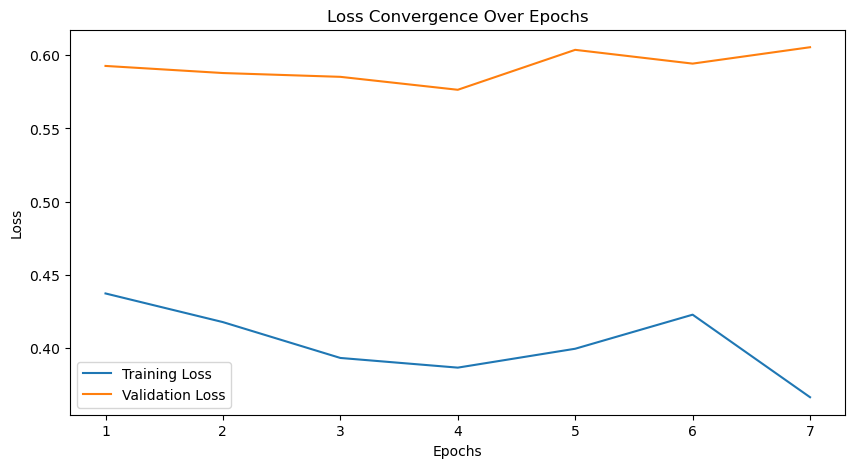

In [93]:
plot_convergence(history_4)

In [13]:
# added drop out after every layer 
vocab_size = min(max_words, len(tokenizer.word_index) + 1)
embedding_dim = 150

model_3 = Sequential()


model_3.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))
model_3.add(Dropout(0.5))
model_3.add(SimpleRNN(units=100, return_sequences=False))
model_3.add(Dropout(0.5)) 
model_3.add(Dense(64, activation='relu'))
model_3.add(Dropout(0.5))
model_3.add(Dense(1, activation='sigmoid'))
model_3.add(Dropout(0.5))

# Compile the model
model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',f1_score, recall_score, precision_score])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_3 = model_3.fit(X_train, y_train, epochs=50, batch_size=32, 
                    validation_data=(X_val, y_val), 
                    callbacks=[early_stopping])

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.5001 - f1_score: 0.1846 - loss: 4.6039 - precision_score: 0.4931 - recall_score: 0.1202 - val_accuracy: 0.4970 - val_f1_score: 0.0000e+00 - val_loss: 0.7942 - val_precision_score: 0.0000e+00 - val_recall_score: 0.0000e+00
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.5292 - f1_score: 0.1853 - loss: 4.4165 - precision_score: 0.4960 - recall_score: 0.1188 - val_accuracy: 0.4970 - val_f1_score: 0.0000e+00 - val_loss: 0.9599 - val_precision_score: 0.0000e+00 - val_recall_score: 0.0000e+00
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.5108 - f1_score: 0.1476 - loss: 4.4745 - precision_score: 0.4930 - recall_score: 0.0893 - val_accuracy: 0.4970 - val_f1_score: 0.0000e+00 - val_loss: 0.7762 - val_precision_score: 0.0000e+00 - val_recall_score: 0.0000e+00
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.5014 - f1_score: 0.2058 - loss: 4.3691 - precision_score: 0.50

In [14]:
loss, accuracy, f1, precision, recall = model_3.evaluate(padd_sequences_test, all_labels_test)

782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.1545 - f1_score: 0.0000e+00 - loss: 1.0536 - precision_score: 0.0000e+00 - recall_score: 0.0000e+00


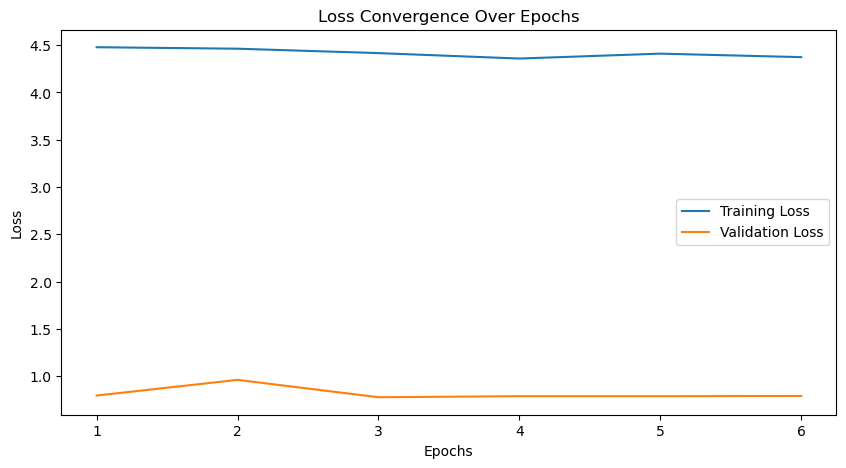

In [18]:
plot_convergence(history_3)